# IMPORTANT NOTES BEFORE RUNNING:
* .h5 might be corrupt (you will get a .h5 error when running model.load_weights()). If so, delete it and redownload it.<br>Original weights from: https://github.com/pedropro/TACO/releases/tag/1.0
* Recommend using google drive as you won't lose progress when runtime disconnects


In [1]:
# Only clone once and drag "/TrashDetection" into "/MyDrive" after next block
!git clone https://github.com/abbesmoe/TrashDetection

Cloning into 'TrashDetection'...
remote: Enumerating objects: 3647, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 3647 (delta 62), reused 79 (delta 25), pack-reused 3504
Receiving objects: 100% (3647/3647), 142.82 MiB | 26.74 MiB/s, done.
Resolving deltas: 100% (1597/1597), done.


In [ ]:
# Suggestion: Use google drive so everything auto saves and you dont lose progress
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
# Install latest versions
!pip install keras==2.6.0
!pip install tensorflow==2.6.0
!pip install 'h5py==2.10.0'

In [1]:
# Change directory to /TrashDetection
%cd /content/gdrive/MyDrive/TrashDetection/

/content/TrashDetection


In [2]:
# Import packages
%matplotlib inline
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import skimage.io
from detector import dataset
from detector import model as modellib
from detector import visualize
from detector.config import Config
from os import path
from PIL import Image

In [3]:
# check class names
# The map is what has all category names.
# The file has categories on the left side and super categories on the right
# which combines multiple categories into one to help create weights
# for categories with not a lot of annotations.
class_map = {}
with open("detector/taco_config/map_10.csv") as csvfile:
    reader = csv.reader(csvfile)
    class_map = {row[0]:row[1] for row in reader}

TACO_DIR = "data/"
round = None 
subset = "train"
dataset = dataset.Taco()
taco = dataset.load_taco(TACO_DIR, round, subset,
                         class_map=class_map, return_taco=True)

dataset.prepare()

print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

creating index...
index created!
Class Count: 11
  0. BG                                                
  1. Bottle                                            
  2. Bottle cap                                        
  3. Can                                               
  4. Cigarette                                         
  5. Cup                                               
  6. Lid                                               
  7. Other                                             
  8. Plastic bag + wrapper                             
  9. Pop tab                                           
 10. Straw                                             


In [4]:
# Create config class and override hyperparameters
# Changed images per gpu so it runs smoother
class TacoTestConfig(Config):
  NAME = "taco"
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  NUM_CLASSES = dataset.num_classes

config = TacoTestConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_CLASSLESS_NMS_THRESHOLD 0.9
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
DETECTION_SCORE_RATIO          True
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MASK_SHARE 

In [5]:
# Create a model in inference mode (so it will run detection and
# not be on the other option "training") and using our config class
# then load the trained weights
# The weights are what predicts the object
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_taco.hy',
                          config=config)

# This is where you might recieve an error if you file is corrupt
# Look how to fix this at the top of this file in the first text block
model.load_weights('weights/mask_rcnn_taco_0100.h5', by_name=True,
                   weights_out_path=None)

Instructions for updating:
Use fn_output_signature instead


In [7]:
# Create a list of class names from the map used for the weights
# Original classes (map_10)
class_names = ["BG","Bottle","Bottle cap","Can","Cigarette","Cup",
               "Lid","Other","Plastic bag + wrapper","Pop tab","Straw"]

# Custom classes we used (map_new)
#class_names = ['BG', 'Bag & wrapper', 'Blister pack', 'Bottle cap',
#               'Can', 'Cardboard', 'Carton', 'Cigarette', 'Container',
#               'Cup', 'Food waste', 'Glass', 'Glass bottle', 'Lid',
#               'Other', 'Other plastic', 'Paper', 'Plastic bottle',
#               'Pop tab', 'Straw', 'Styrofoam', 'Tube']

In [8]:
# Select an image to test. Store in in static/uploads/
imagePath = "static/uploads/"
imageName = "000013.jpg"
img = Image.open(os.path.join(imagePath, imageName))

fileName = os.path.splitext(imageName)[0]
fileExtension = os.path.splitext(imageName)[1]

# If the uploaded file isn't .jpg, save it as one
if fileExtension != '.jpg':
  img.convert('RGB').save("{}{}.jpg".format(imagePath, fileName))
  imageName = "{}.jpg".format(fileName)

image = skimage.io.imread(os.path.join(imagePath, imageName))

In [9]:
# run detection on the uploaded image
r = model.detect([image], verbose=0)[0]

In [10]:
# This function grabs all data that was found in detection
def min_accuracy(r,a):
  result = {'rois': [], 'masks': [], 'class_ids': [], 'scores': []}
  indecies = []
  for i,ele in enumerate(r['scores']):
    # It then compares the accuracy scores with the given score and
    # displays the ones >= a
    if ele >= a:
      result['rois'].append(r['rois'][i])
      result['class_ids'].append(r['class_ids'][i])
      result['scores'].append(r['scores'][i])
      indecies.append(i)
  
  result['masks'] = r['masks'][:,:,indecies]

  result['rois'] = np.asarray(result['rois'])
  result['masks'] = np.asarray(result['masks'])
  result['class_ids'] = np.asarray(result['class_ids'])
  result['scores'] = np.asarray(result['scores'])
  return result

# Set your custom min accuracy down here
r = min_accuracy(r,0.7)
print(r['class_ids'])

[1 2]


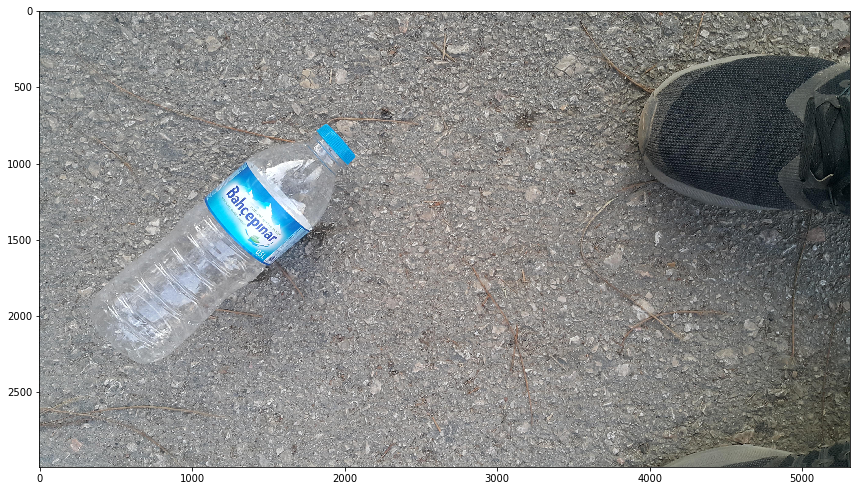

In [11]:
# Display original image
plt.figure(figsize=(12,10))
skimage.io.imshow(image)

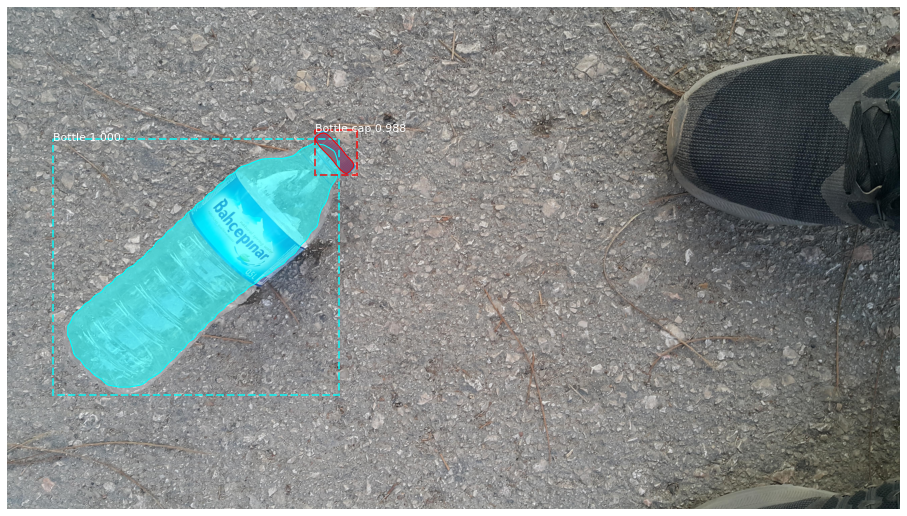

In [12]:
# Display annotated image
# This function also saves the image as a .jpg and stores it
# in static/annotated_images
visualize.display_instances(image, imageName, r['rois'], r['masks'],
                            r['class_ids'], class_names, r['scores'])

# Blocks for filtering
This section is how we save the annotated data to data.json and also how we look into that file for our search page

In [13]:
# run only once to create the file or if you want to empty data.json
with open('data.json', 'w') as f:
  data = {"Images":[]}

In [14]:
# Run after every detection to write data in json file
size = len(r['class_ids'])
i = 0
# Creates list of object names that were detected
classNameList = []
while i < size:
  obj_name = class_names[r['class_ids'][i]]
  classNameList.append(obj_name)
  i = i + 1

def write_json(data, filename="data.json"):
  with open(filename, "w") as f:
    json.dump(data, f, indent=4)

# Formats the file as each image in a dictionary with name, quantity,
# and class names
img_data = {}
img_data["Name"] = "annotated_{}".format(imageName)
img_data["Quantity"] = len(classNameList)
img_data['Classes'] = classNameList

data['Images'].append(img_data)

write_json(data)

In [15]:
# Use pandas to display data.json more neatly
pd.set_option("display.max_rows", None, "display.max_columns", None)

with open('data.json') as json_data:
    data = json.load(json_data)

df = pd.DataFrame(data['Images'])
print(df)

                   Name  Quantity               Classes
0  annotated_000013.jpg         2  [Bottle, Bottle cap]
